## Setup

In [1]:
from causallearn.search.ConstraintBased.PC import pc
import pandas as pd
import numpy as np
import os
from IPython.display import display, Image
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.graph.SHD import SHD
from sklearn.model_selection import KFold
import itertools

/Users/nathanluskey/opt/anaconda3/envs/causal_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Get File Paths
google_drive_path = "/Users/nathanluskey/Library/CloudStorage/GoogleDrive-nluskey@andrew.cmu.edu/My Drive/80816_Project/Data/"

filename = "ChurnForBankCustomers_optbinning.csv"

full_filename = os.path.join(google_drive_path, filename)

assert os.path.isfile(full_filename)

In [3]:
# Convert dataframe to numpy array
df = pd.read_csv(full_filename)
display(df.dtypes)
display(df.head(5))

CreditScore         int64
Geography          object
Gender             object
Age                 int64
Tenure              int64
Balance             int64
NumOfProducts       int64
HasCrCard            bool
IsActiveMember       bool
EstimatedSalary     int64
Exited               bool
dtype: object

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,2,France,Female,6,1,0,0,True,True,3,True
1,2,Spain,Female,6,0,1,0,False,True,4,False
2,1,France,Female,6,4,6,1,True,False,4,True
3,5,France,Female,5,0,0,1,False,False,3,False
4,7,Spain,Female,7,1,5,0,True,True,2,False


In [4]:
for col in df.columns:
    unique_vals = sorted(df[col].unique())
    data_to_num = {data: num for num, data in enumerate(unique_vals)}
    df[col] = df[col].map(data_to_num)

display(df.dtypes)
display(df.head(5))

CreditScore        int64
Geography          int64
Gender             int64
Age                int64
Tenure             int64
Balance            int64
NumOfProducts      int64
HasCrCard          int64
IsActiveMember     int64
EstimatedSalary    int64
Exited             int64
dtype: object

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,2,0,0,6,1,0,0,1,1,3,1
1,2,2,0,6,0,1,0,0,1,4,0
2,1,0,0,6,4,6,1,1,0,4,1
3,5,0,0,5,0,0,1,0,0,3,0
4,7,2,0,7,1,5,0,1,1,2,0


## Run PC

In [5]:
data = df.to_numpy()

# default parameters
cg = pc(data, indep_test="chisq")

Depth=5, working on node 10: 100%|██████████| 11/11 [00:00<00:00, 1541.46it/s]


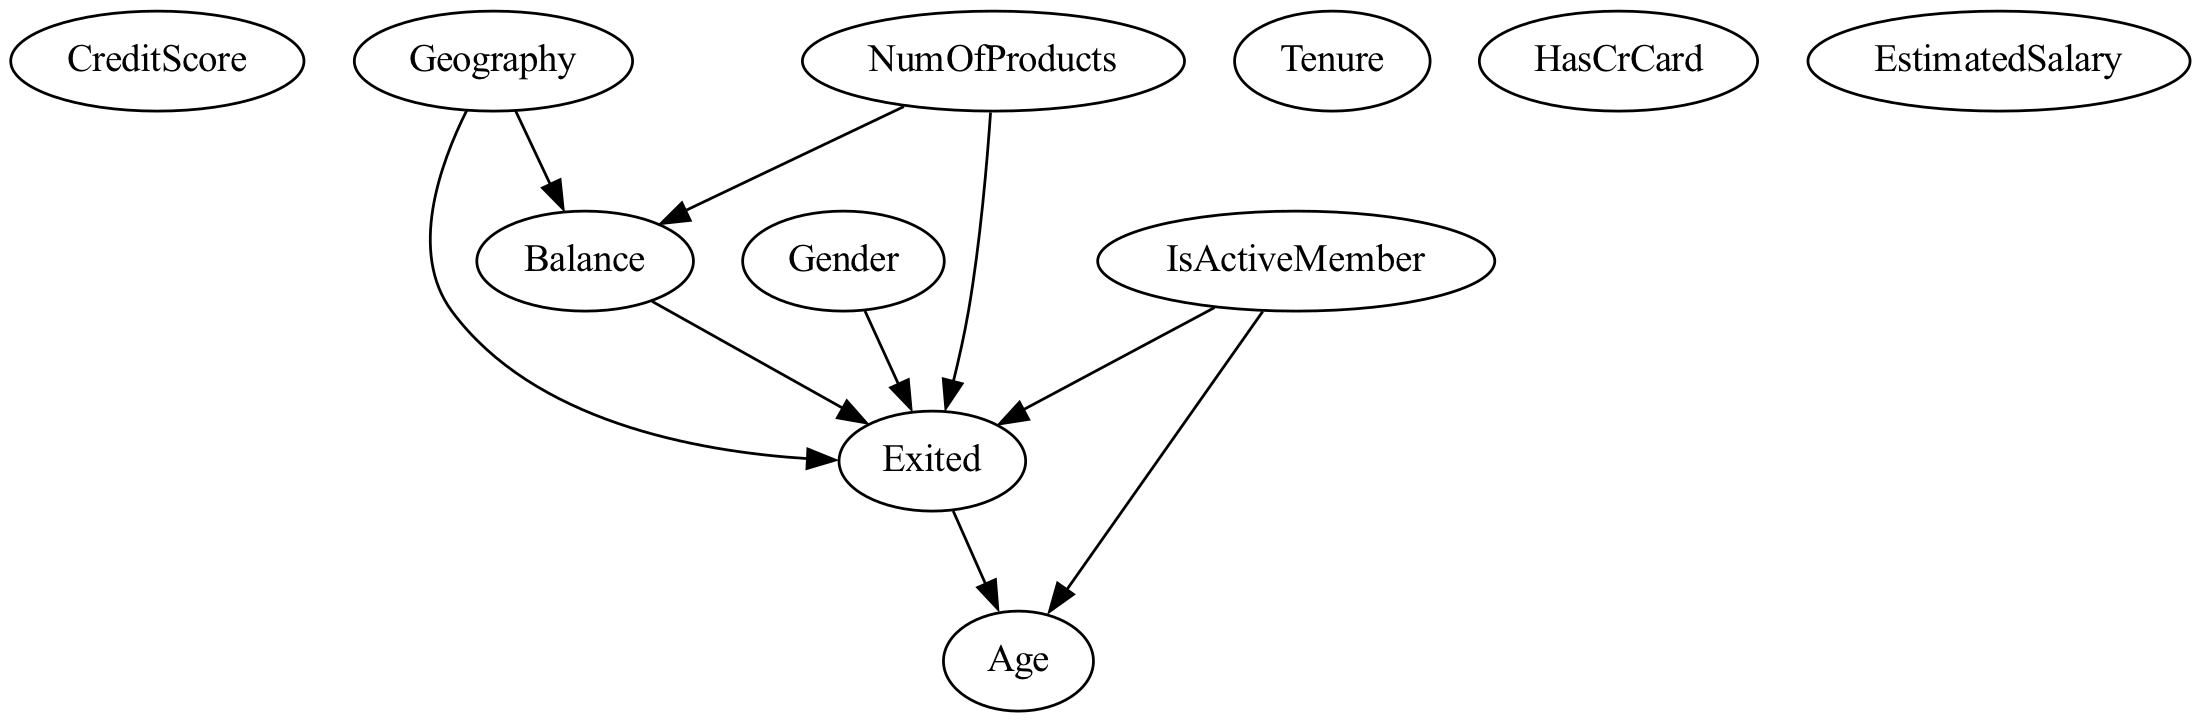

In [6]:
filename = "PC_output.png"
pyd = GraphUtils.to_pydot(cg.G, labels=df.columns)
pyd.write_png(filename)
Image(filename=filename)

## Calculate Hamming Distance

In [10]:
num_splits = 5
kf = KFold(n_splits=num_splits, shuffle=True, random_state=80816)

print(kf) 

all_graphs = [None] * num_splits

for i, (train_index, _) in enumerate(kf.split(data)):
    curr_data = data[train_index]
    curr_cg = pc(curr_data, indep_test="chisq")
    all_graphs[i] = curr_cg

    # # draw the graph as a sanity check
    # filename = f"PC_outputs/PC_{i}.png"
    # pyd = GraphUtils.to_pydot(curr_cg.G, labels=df.columns)
    # pyd.write_png(filename)

KFold(n_splits=5, random_state=80816, shuffle=True)


Depth=5, working on node 10: 100%|██████████| 11/11 [00:00<00:00, 1330.49it/s]


In [8]:
all_hamming_distances = []
all_permutations = itertools.permutations(all_graphs, 2)

for g1, g2 in all_permutations:
    hamming_distance = SHD(g1.G, g2.G).get_shd()
    all_hamming_distances.append(hamming_distance)


all_hamming_distances = np.array(all_hamming_distances)

display(f"Mean: {all_hamming_distances.mean():0.2f} Variance: {all_hamming_distances.var()}")

'Mean: 1.80 Variance: 0.9600000000000002'